In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import yaml
import numpy as np
import math

# Import Custom Class
from MujocoHandler import MujocoHandler

In [2]:
# Define constants for stiffness and damping

xml_template = '''
<mujoco>
    <visual>
        <global offwidth="{render_width}" offheight="{render_height}" />
    </visual>
    <option><flag gravity="enable" contact="enable" /></option>
    <option timestep="{ts:e}"/>
    <compiler angle="degree" />

    <default>
        <geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".999 .999 .001" solref=".001 1" margin="0.001" group="0"/>
    </default>

    <worldbody>
        <light name="top" pos="0 0 3"/>

        <!-- Main body -->
        <body name="body_1" pos="0 0 0.05">
            <joint name="prismatic_1" type="slide" axis="0 0 1" pos="0 0 0"/>
            <geom type="box" size="0.025 0.025 0.025" pos="0 0 0" rgba="1 0 1 1" mass="0.01"/>
            <!--<camera name="camera_1" mode="targetbody" target="box" pos="0 0 -0.5" quat="1 0 0 0" fovy="45"/>-->

            <!-- First leg attached to the main body -->
            <body name="leg_1" pos="0.025 0 -0.025">
                <joint name="joint_1" type="hinge" axis="0 1 0" pos="0 0 0" limited="true" range="0 180"/>
                <geom type="box" size="0.025 0.0125 0.001" pos="0.025 0 0" rgba="0 1 1 1" mass="0.001"/>

                <!-- Second leg attached to the first leg -->
                <body name="leg_2" pos="0.05 0 0">
                    <joint name="joint_2" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k:e}" damping="{b:e}"/>
                    <geom type="box" size="0.025 0.0125 0.001"  pos="0.025 0 0" rgba="0 0 1 1" mass="0.001"/>
                </body>
            </body>
        </body>

        <!-- Floor plane -->
        <body name="floor" pos="0 0 0">
            <geom pos="0 0 0" size="1 1 0.05" type="plane" rgba="1 1 1 1"/>
        </body>
    </worldbody>

    <contact>
        <exclude body1="body_1" body2="leg_1" />
        <exclude body1="leg_1" body2="leg_2" />  
    </contact>

    <actuator>
        <motor name="motor_1" joint="joint_1"/>
    </actuator>

    <sensor>
        <framepos name="body_pos" objtype="body" objname="body_1"/>
    </sensor>
</mujoco>
'''

In [3]:
Vnom = 6
G = 55.5
t_stall = 15/100/G
i_stall = .6
R = Vnom/i_stall
i_nl = .2
w_nl = .66*1000*math.pi/180*G

kt = t_stall/ i_stall
# kv= Vnom/w_nl
ke = kt

b_calc = kt*i_nl/w_nl

ts = 1e-4
V_control = 5

b_fit = 1.404e-6
kp_fit = 8.896

In [4]:
def legController(model,data):
    # Current state
    w = data.qvel[1]  # Current velocity of joint 1
    actual = data.qpos[1]  # Current position of joint 1

    desired = math.pi if data.time > 1 else 0

    error = desired-actual

    V = kp_fit*error

    V = max(min(V, V_control), -V_control)
    
    torque = (kt * (V - (ke * w * G)) / R - b_fit * w * G) * G

    data.ctrl[0] = torque # control first joint
    return

In [5]:
def run_sim(k):
    xml = xml_template.format(
                                render_width = 800,
                                render_height = 600,
                                ts = ts,
                                
                                k=k,
                                b =k/100)

    ic = { 
            "qpos":  [0, 0, 0] # spawn box at floor (PRR)
        }
    
    model = MujocoHandler(  xml=xml, 
                            duration=5, 
                            fps=30,
                            resolution = (800,600),
                            initConditions=ic
                            )\
                            .setController(legController)\
                            .runSim(render=True)
    
    # print(xml)
    return model

In [6]:
boxLeg = run_sim(k=1)
boxLeg

Running Simulation:   0%|          | 0/50000 [00:00<?, ?step/s]

MujocoHandler(
  Duration: 5 [30 fps, timestep = 1e-04]
  Gravity: [ 0.    0.   -9.81],
  Resolution: 800x600
  Bodies (5): world, body_1, leg_1, leg_2, floor
  Joints (3): prismatic_1, joint_1, joint_2
  Actuators (1): motor_1
  Initial Conditions: {'qpos': [0, 0, 0]}
  Controller Enabled: True
)

""

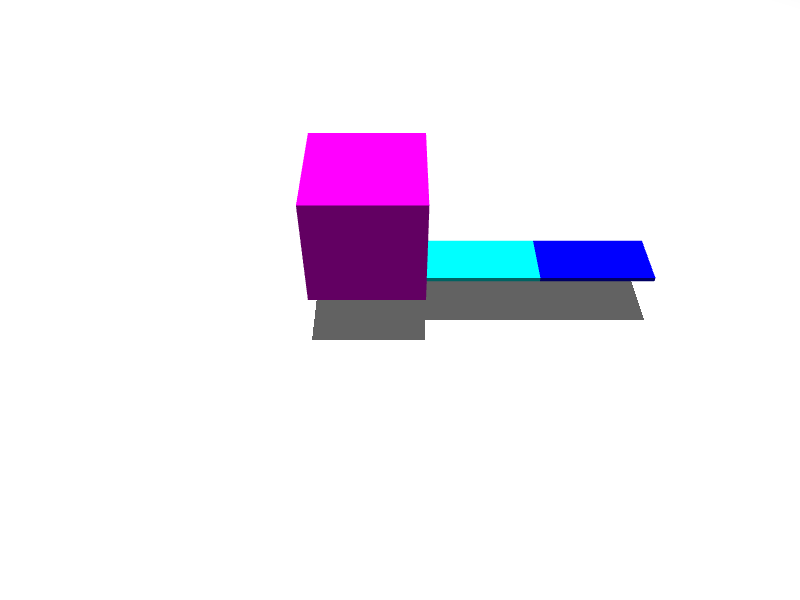

In [7]:
boxLeg.renderMedia()

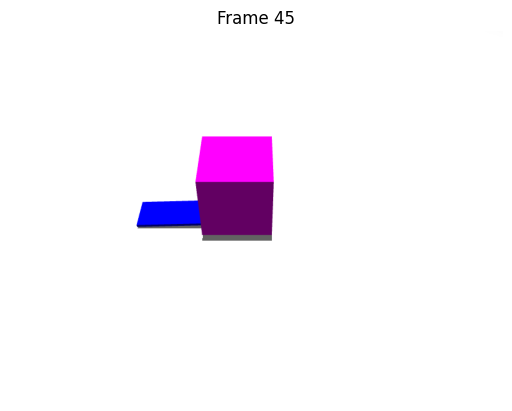

In [8]:
boxLeg.renderFrame(t=1.5)

In [9]:
def plotStiffness(t,q,k):
    plt.plot(t,q)
    plt.legend(["Body (Z)","Hip Joint (Theta)", "Knee Joint (Theta)"])
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement")
    plt.title(f"Box Pos. Over Time (k={k})",loc="center")
    plt.show()

In [10]:
body_height = boxLeg.simData['qpos'][:,0]
t = boxLeg.simData['time']

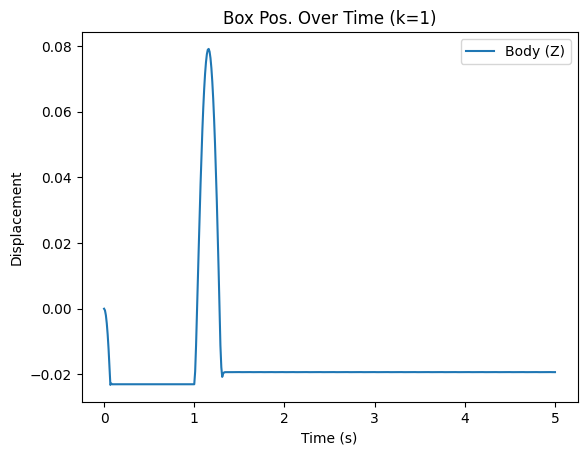

In [11]:
plotStiffness(t,body_height,k=1)

In [12]:
maxZ = []
kArr = []

def fun(k):
    k = k.item() if isinstance(k, np.ndarray) else k

    model = run_sim(k)
    
    pris_pos = model.simData['qpos'][:,0].max() # up is position, primatic max position
    
    maxZ.append(pris_pos)
    kArr.append(k)


    error = (0 - pris_pos)
    
    return error

In [13]:
ini_k = [1e-2]

In [14]:
import scipy.optimize as so

results = so.minimize(
    fun, 
    x0=ini_k,
    bounds=[(1e-3,1e1)],
    method='nelder-mead', 
    options={'xatol': 1e-2, 'fatol': 1e-2}
)

Running Simulation:   0%|          | 0/50000 [00:00<?, ?step/s]

Running Simulation:   0%|          | 0/50000 [00:00<?, ?step/s]

In [15]:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.09130707148934396
             x: [ 1.050e-02]
           nit: 1
          nfev: 2
 final_simplex: (array([[ 1.050e-02],
                       [ 1.000e-02]]), array([-9.131e-02, -8.980e-02]))

In [16]:
k_best = float(*results.x)
k_best

0.0105

In [17]:
bestModel = run_sim(k_best)

Running Simulation:   0%|          | 0/50000 [00:00<?, ?step/s]

In [18]:
t = bestModel.simData['time']
body_height_best = boxLeg.simData['qpos'][:,0]

Best Model

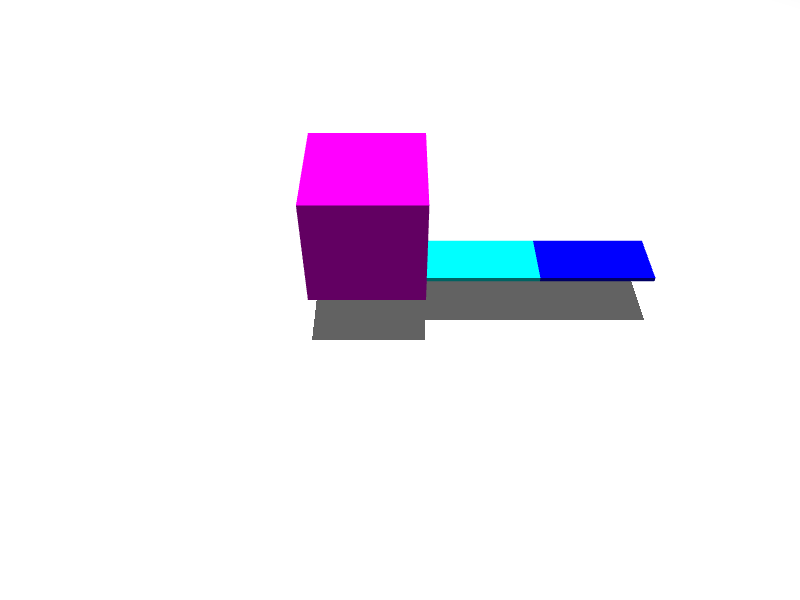

In [19]:
bestModel.renderMedia(title="Best Model")

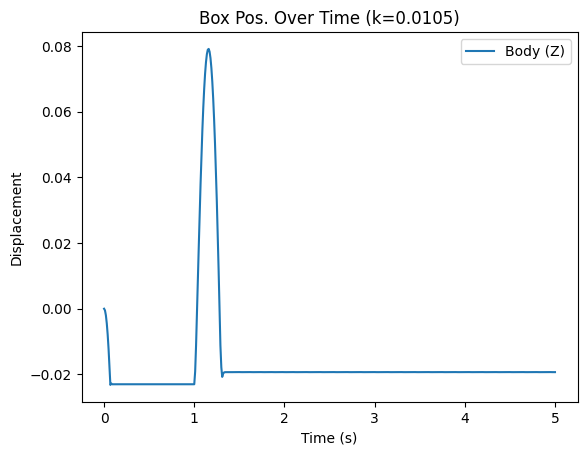

In [20]:
plotStiffness(t,body_height_best,k_best)

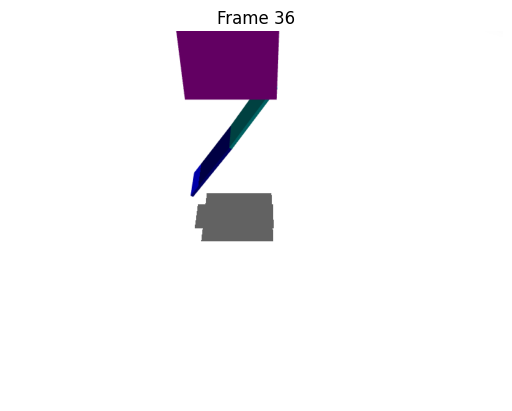

In [21]:
max_idx = np.argmax(body_height_best)
bestModel.renderFrame(t=1.2)